# Lab 08: Airline Tweets Sentiment Analysis

---
author: Ye Yuan
date: November 20, 2024
embed-resources: true
---

## Introduction

Air travel can often lead to frustration and dissatisfaction among passengers, resulting in numerous tweets targeting airlines. As part of the social team of a major US airline, we aim to enhance customer experience by promptly addressing negative feedback and acknowledging positive interactions. The objective is to build a sentiment classification model that efficiently processes tweets and classifies them into one of three sentiments: negative, neutral, or positive. This model will serve as a tool to assist customer service representatives in prioritizing tasks and maintaining customer satisfaction.

## Methods

In [110]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump
import warnings
import matplotlib.pyplot as plt

### Data

To achieve the goal of building a sentiment classifier for airline tweets, we use a dataset sourced from Kaggle, specifically the Twitter US Airline Sentiment dataset. This dataset contains labeled data for tweets directed at major U.S. airlines, offering insight into passenger sentiments and the issues they encounter during air travel. The data was originally scraped in February 2015, and contributors were tasked with classifying tweets into one of three sentiment categories: positive, neutral, and negative. Negative tweets were further categorized into specific reasons such as "late flight" or "rude service."

Response Variable:

sentiment: The sentiment of the tweet, labeled as one of three categories:

negative
neutral
positive

Features:

text: The full content of the tweet, capturing user feedback, complaints, or acknowledgments.


In [111]:
# load data
tweets = pd.read_csv(
    "https://cs307.org/lab-08/data/tweets.csv",
)
tweets_train, tweets_test = train_test_split(
    tweets,
    test_size=0.25,
    random_state=42,
)

In [112]:
tweets_train

,sentiment,airline,text
2233,positive,Delta,@JetBlue Then en route to the airport the rebo...
10733,negative,United,@united now you've lost my bags too. At least...
400,neutral,US Airways,"@USAirways Hi, can you attach my AA FF# 94LXA6..."
7615,positive,United,"@United, will you fill it? Yes they will. Than..."
4099,negative,American,@AmericanAir thanks! I hope we get movies. Tv'...
...,...,...,...
5734,negative,United,@united Can i get a refund? I would like to bo...
5191,neutral,Virgin America,@VirginAmerica what is your policy on flying a...
5390,negative,United,@united I'm not sure how you can help. Your fl...
860,neutral,Virgin America,@VirginAmerica LAX to EWR - Middle seat on a r...


In [113]:
# summary statistics
# Calculate counts
airline_counts = tweets_train['airline'].value_counts()

# Calculate proportions
airline_proportions = (airline_counts / airline_counts.sum())*100

# Create a summary DataFrame
airline_summary = pd.DataFrame({
    'Count': airline_counts,
    'Proportion (%)': airline_proportions.round(1)
})

print(airline_summary)

                Count  Proportion (%)
airline                              
United           2166            26.3
US Airways       1664            20.2
American         1551            18.8
Southwest        1347            16.4
Delta            1239            15.0
Virgin America    268             3.3


In [114]:
# Define the words to count
target_words = ['cancelled', 'please', 'thanks']

# Initialize CountVectorizer with lowercasing and no stop word removal
vectorizer = CountVectorizer(lowercase=True, stop_words=None)

# Fit and transform the training text data
X_counts = vectorizer.fit_transform(tweets_train['text'])  # Use the 'text' column

# Convert to DataFrame for easier manipulation
word_df = pd.DataFrame(
    X_counts.toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Calculate the total counts for each target word
word_counts = word_df[target_words].sum().reset_index()
word_counts.columns = ['Word', 'Count']

print(word_counts)


        Word  Count
0  cancelled    595
1     please    325
2     thanks    587


The dataset reveals a skewed distribution of tweets, with United Airlines receiving the highest number of tweets (26.3%), followed by US Airways (20.2%) and American Airlines (18.8%). Virgin America received significantly fewer tweets (3.3%).

When analyzing the text of the tweets, the word "cancelled" appears most frequently (595 occurrences), highlighting a common source of frustration for customers. Words like "please" (325 occurrences) and "thanks" (587 occurrences) often indicate attempts at polite communication or acknowledgment, which are relevant for sentiment classification.

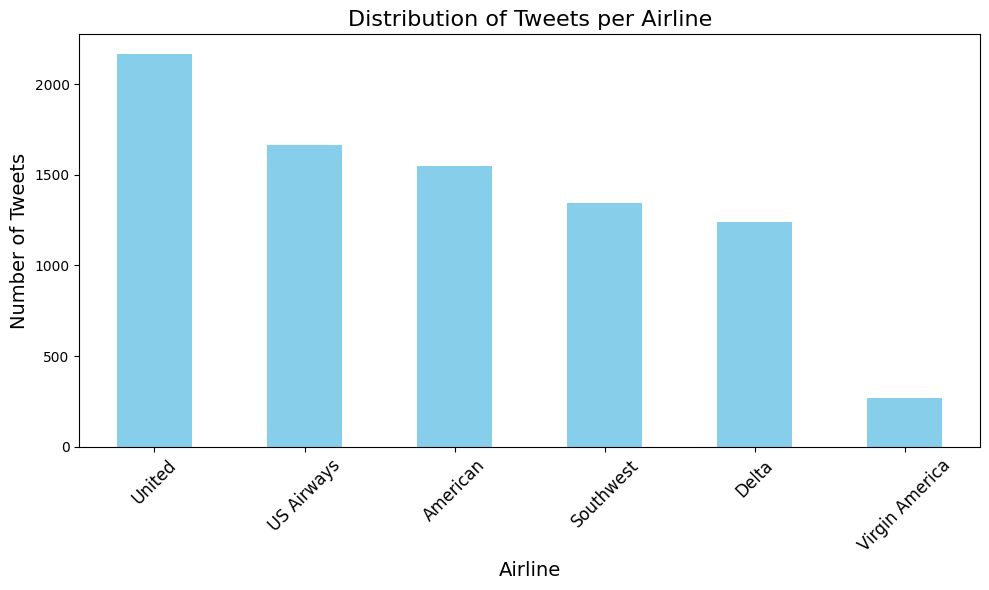

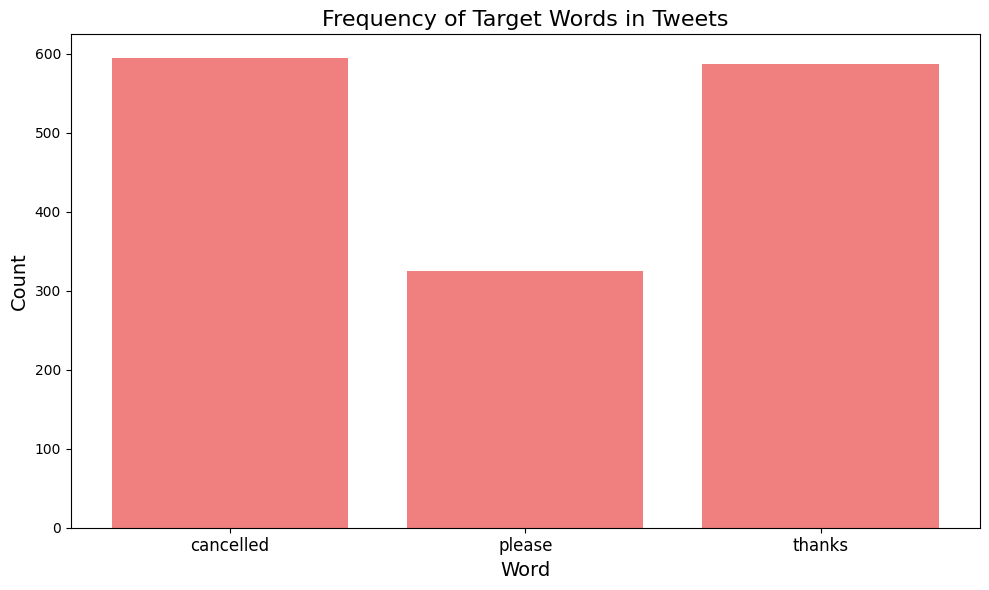

In [115]:
# visualizations
airline_counts = pd.Series({
    'United': 2166,
    'US Airways': 1664,
    'American': 1551,
    'Southwest': 1347,
    'Delta': 1239,
    'Virgin America': 268
})

word_counts = pd.DataFrame({
    'Word': ['cancelled', 'please', 'thanks'],
    'Count': [595, 325, 587]
})

# Visualization 1: Distribution of Tweets per Airline
plt.figure(figsize=(10, 6))
airline_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Tweets per Airline', fontsize=16)
plt.xlabel('Airline', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

# Visualization 2: Word Frequency for Target Words
plt.figure(figsize=(10, 6))
plt.bar(word_counts['Word'], word_counts['Count'], color='lightcoral')
plt.title('Frequency of Target Words in Tweets', fontsize=16)
plt.xlabel('Word', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

Distribution of Tweets per Airline:
This chart shows the number of tweets per airline, with United Airlines receiving the most tweets (26.3%) and Virgin America the fewest (3.3%). The distribution highlights varying levels of customer interaction across airlines, with United being the most discussed.

Frequency of Target Words in Tweets:
This chart highlights the frequency of key words, with "cancelled" (595 occurrences) being the most common, followed by "thanks" (587) and "please" (325). These words indicate recurring themes like flight cancellations and polite customer inquiries.

### Models

In [116]:
# process data for ML
# create X and y for train data
X_train = tweets_train["text"]
y_train = tweets_train["sentiment"]

# create X and y for test data
X_test = tweets_test["text"]
y_test = tweets_test["sentiment"]

In [117]:
# train models
# Define pipeline with TfidfVectorizer
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=500, ngram_range=(1,2))),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced'))
])

# Hyperparameters for GridSearch
param_grid = {
    'vectorizer__max_features': [300, 500, 1000, 2000, 5000, 10000, 20000, 40000, 60000],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2']  # 'penalty' l2 is compatible with 'lbfgs' solver
}

# Stratified K-Fold Cross-Validation to maintain class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch with cross-validation
grid = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_

# Evaluate on test data
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Best Parameters:", grid.best_params_)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'vectorizer__max_features': 60000, 'vectorizer__ngram_range': (1, 2)}
Test Accuracy: 0.81
              precision    recall  f1-score   support

    negative       0.87      0.90      0.88      1720
     neutral       0.65      0.63      0.64       551
    positive       0.76      0.69      0.72       474

    accuracy                           0.81      2745
   macro avg       0.76      0.74      0.75      2745
weighted avg       0.81      0.81      0.81      2745



Model Development

The sentiment classification model was developed using a pipeline that combines TfidfVectorizer for feature extraction and Logistic Regression for classification. The pipeline was optimized using GridSearchCV with stratified 5-fold cross-validation to maintain class distribution. Key components of the model:

Vectorization:
The TfidfVectorizer was configured with a maximum of 500-60,000 features and n-gram ranges of 1 to 2, capturing both unigrams and bigrams.
Classifier:
Logistic Regression with the lbfgs solver was chosen for its efficiency and ability to handle multiclass classification. The class weights were balanced to address potential class imbalances.
Hyperparameter Tuning:
Parameters such as max_features, ngram_range, and Logistic Regression’s regularization strength (C) were tuned. A total of 54 hyperparameter combinations were evaluated.
The best-performing model had the following parameters:

vectorizer__max_features: 60,000
vectorizer__ngram_range: (1, 2)
classifier__C: 10

## Results

In [118]:
# report model metrics
mod=grid.best_estimator_
from joblib import dump
dump(mod, "airline-sentiment.joblib")

['airline-sentiment.joblib']

The final model achieved:

Overall Accuracy: 81% on the test set.
Performance Metrics:
Negative tweets: Precision 87%, Recall 90%, F1-Score 88%.
Neutral tweets: Precision 65%, Recall 63%, F1-Score 64%.
Positive tweets: Precision 76%, Recall 69%, F1-Score 72%.
The model performed best on negative tweets, aligning with the primary goal of prioritizing customer service interventions for complaints. While the performance for neutral tweets was lower, the model still provides reasonable classification for all categories.

## Discussion

The model demonstrates strong performance, particularly for identifying negative tweets, making it well-suited for the airline's goal of improving customer service responsiveness. Positive tweet classification is also effective, allowing for automatic acknowledgments. The lower performance on neutral tweets is less critical but could lead to minor misclassification issues.

Potential Mistakes and Impact:

False Negatives (misclassifying negative tweets):
Severity: High. Customer issues may go unresolved, leading to dissatisfaction.
False Positives (misclassifying neutral/positive tweets as negative):
Severity: Moderate. This may increase workload for customer service but ensures responsiveness.
Neutral misclassifications:
Severity: Low. Neutral tweets are less critical for immediate response.
Recommendations:

Model Improvement: Incorporate additional data or advanced NLP techniques to better capture nuances in neutral tweets.
Periodic Retraining: Regularly update the model with new data to maintain accuracy as language and trends evolve.
Human Oversight: Use the model as a triage tool with human verification for high-stakes responses.

### Conclusion

The trained sentiment classification model achieved an accuracy of 81%, with strong performance in identifying negative tweets (F1-Score: 88%) and reasonable results for positive tweets (F1-Score: 72%). These strengths ensure customer complaints are flagged for immediate attention while positive feedback is acknowledged automatically, aligning with the airline's customer service goals. Although performance on neutral tweets was lower (F1-Score: 64%), this has minimal impact on the overall objective. Future improvements, such as refining pre-processing, incorporating additional data, or exploring advanced NLP models, could enhance accuracy, particularly for neutral tweets. The model is highly recommended for deployment, offering a practical and effective tool to improve customer service responsiveness and operational efficiency.